In [1]:
import warnings
from tensorflow.keras.callbacks import EarlyStopping
from EEGModels import EEGNet
import numpy as np
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
import moabb
from moabb.datasets import BNCI2014008
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import P300
from keras.models import model_from_json
from preprocessing import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from pyriemann.estimation import Xdawn, XdawnCovariances


Using TensorFlow backend.


In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

moabb.set_log_level("info")

In [3]:
# Moaab BNCI2014008 dataset
dataset = BNCI2014008()
dataset.subject_list = dataset.subject_list[:3]
datasets = [dataset]
paradigm = P300()

In [4]:
subject_list = [1]
X_data, y_data, meta = paradigm.get_data(dataset=dataset, subjects=subject_list)
X_data = X_data[:, :, :256] # our time saamples are only 256


In [5]:
from preprocessing import *
subjects_1 = ("FnF_amin","FnF_edvin", "FnF_marcus", "FnF_felix")
sessions_1 = ("1","2", "3", "4", "5", "6")
X_experiment, y_experiment = dataset_array(subjects_1,sessions_1)

subjects_1_extra = ("FnF_amin","FnF_edvin", "FnF_marcus", "FnF_felix")
sessions_1_extra = ("1","2", "3", "4", "5", "6")
X_experiment_extra, y_experiment_extra = dataset_array(subjects_1_extra,sessions_1_extra) # add a part of our data to the dataset 
# which is created from the Moaab dataset in a more balanced way, to get the EEGnet more compatible with our data while training

print(X_experiment.shape, y_experiment.shape)


(500, 4, 256) (500,)


In [6]:
#y_validation= np.array([objmap(el) for el in y_validation])  #obj

y_experiment= np.array([FNFmap(el) for el in y_experiment])  #FNF

y_experiment_extra= np.array([FNFmap(el) for el in y_experiment_extra])  #FNF

y_data= np.array([Targetmap(el) for el in y_data])  #target for MOAAB
print(y_experiment_extra.shape)

(500,)


In [7]:
from pandas import Series

combined = list(zip(y_data, X_data))
combined

y_balanced = []
X_balanced = []
count, jump = 0 ,0
y_size=len(y_data)
for (y, x) in combined:
    if y == 1:
        y_balanced.append(y)
        X_balanced.append(x)
    elif y==0 and count < 4000:
        if not(jump): # to select evry other smaple 0's out of the Moaab dataset to reduce imbalancy 
            y_balanced.append(y)
            X_balanced.append(x)
        jump = not(jump)
        count +=1

y_balanced = np.asarray(y_balanced)
X_balanced = np.asarray(X_balanced)

In [8]:
print(X_balanced.shape, y_balanced.shape)

(2450, 8, 256) (2450,)


In [9]:
combined_balanced=list(zip(X_balanced,y_balanced))
np.random.seed(0)
np.random.shuffle(combined_balanced) # to shuffle the new dataset to make it more balanced
y_balanced_shuffled = []
X_balanced_shuffled = []

for (x,y) in combined_balanced:
    y_balanced_shuffled.append(y)
    X_balanced_shuffled.append(x)
    
y_balanced_shuffled = np.asarray(y_balanced_shuffled)
X_balanced_shuffled = np.asarray(X_balanced_shuffled)
#y_balanced_n = y_balanced_shuffled[:1700]
print(y_balanced_shuffled.shape, X_balanced_shuffled.shape)

(2450,) (2450, 8, 256)


In [10]:
XDAWN_model=Xdawn(nfilter=2) # to reduce the number of the channels in the new dataset, 8, as many as ours, 4
#XDAWN_model=XdawnCovariances(nfilter=4)
X_data=XDAWN_model.fit_transform(X_balanced_shuffled, y_balanced_shuffled)
y_balanced_shuffled = np.concatenate((y_balanced_shuffled, y_experiment_extra)).reshape(-1,1)


In [11]:
# preprocessing including spliting, outlier removing, rescaling, and reshaping of both Moaab BNCI2014009 dataset (as X_data and y_data)to train and validate the base model
# and the experiment dataset (as X_data_experiment and y_data_experiment) divided into two sets, one to do transfer learning, and another to validate the learning

X_train_experiment, X_validation_experiment, y_train_experiment, y_validation_experiment= spliter(X_experiment,y_experiment, 0.75)

X_train, X_validation, y_train, y_validation = spliter(X_data,y_data, 2/3)

X_train = outlier_free(X_train)
X_experiment_extra = outlier_free(X_experiment_extra)
X_train_experiment = outlier_free(X_train_experiment)
X_validation_experiment = outlier_free(X_validation_experiment)
print(X_experiment_extra)

[[[-23.63846997 -23.9184405  -24.0158703  ... -22.25317543 -21.71768637
   -21.8651299 ]
  [-22.90878205 -22.82969952 -22.71640205 ... -23.38169556 -23.34883116
   -23.85583718]
  [-24.6711865  -24.69418634 -24.10778817 ... -24.77482241 -25.12322321
   -25.99776674]
  [-70.7106407  -76.78282453 -81.66439712 ...   5.95786615   7.09752042
     8.33790908]]

 [[-31.73674058 -31.69395887 -31.82815695 ... -32.94737384 -32.86150681
   -33.01137634]
  [-25.23322292 -24.95421618 -25.72030876 ... -28.11039188 -27.8173175
   -27.36832992]
  [-23.49026016 -22.68322066 -22.28309507 ... -25.77797848 -25.59786926
   -25.69349682]
  [ -8.27381798  -5.9460289   -2.44295706 ... -11.82041599 -12.19653952
   -11.84542906]]

 [[-33.2742351  -33.65253941 -33.42645015 ... -28.85563855 -28.89982687
   -29.17601184]
  [-27.34730662 -27.66944072 -28.18449315 ... -30.53158183 -32.35837366
   -33.4438889 ]
  [-30.77097073 -30.08117949 -29.58198319 ... -28.56760951 -29.0562143
   -29.67629606]
  [-14.4775901  -15

In [12]:

#X_train = rescalar(X_train)
X_experiment_extra = rescalar(X_experiment_extra)
X_train_experiment = rescalar(X_train_experiment)
X_validation_experiment = rescalar(X_validation_experiment)
print(X_experiment_extra)

[[[ 0.58204078  0.57256283  0.56120281 ... -0.48068623 -0.44834192
   -0.42881822]
  [ 0.61789989  0.62001144  0.6128862  ... -0.56903229 -0.57136226
   -0.5706226 ]
  [ 0.53128991  0.53875491  0.55754699 ... -0.67809305 -0.70518626
   -0.72319902]
  [-1.73123057 -1.73132919 -1.73163601 ...  1.72781157  1.72489044
    1.72263983]]

 [[-1.1110058  -1.09503422 -1.02275257 ... -1.05477286 -1.0790325
   -1.09635433]
  [-0.35467043 -0.38365769 -0.46794977 ... -0.43884727 -0.41874946
   -0.371204  ]
  [-0.15197023 -0.14395523 -0.15573248 ... -0.14184531 -0.12822427
   -0.15598234]
  [ 1.61764646  1.62264714  1.64643481 ...  1.63546544  1.62600624
    1.62354067]]

 [[-0.94079712 -1.00652931 -1.02035385 ...  0.08388836  0.01715505
   -0.07642922]
  [-0.12159993 -0.1484918  -0.20847148 ... -1.59761648 -1.39883614
   -1.25216002]
  [-0.59480558 -0.49435979 -0.42491689 ...  0.37287321 -0.04687277
   -0.2142494 ]
  [ 1.65720263  1.6493809   1.65374221 ...  1.1408549   1.42855385
    1.54283864]]


In [13]:
X_data=np.vstack((X_data,X_experiment_extra)) # adding a partr of our Face/Nonface dataset to the new dataset

X_train, X_validation, y_train, y_validation = spliter(X_data,y_balanced_shuffled, 0.5)

X_train = reshaper(X_train)
X_validation = reshaper(X_validation)
X_train_experiment = reshaper(X_train_experiment)
X_validation_experiment = reshaper(X_validation_experiment)


In [14]:
print(X_train.shape)


(1400, 4, 256, 1)


In [21]:
#fitting EEGNet model with training dataset
model = EEGNet(nb_classes = 1 , Chans = 4, Samples = 256)
callback = EarlyStopping(monitor='val_accuracy', patience=10) # early stopping
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.01)
model.compile(loss='binary_crossentropy',  optimizer=opt, metrics=['accuracy'] )
fittedModel= model.fit(X_train, y_train, validation_data=(X_validation, y_validation),callbacks=[callback], epochs=1000, verbose=1)

 # This callback will stop the training when there is no improvement in
 # the loss for 5 consecutive epoch

model.summary()

Epoch 1/1000
44/44 [==============================] - 3s 64ms/step - loss: 10.8596 - accuracy: 0.2879 - val_loss: 12.0142 - val_accuracy: 0.2121
Epoch 2/1000
44/44 [==============================] - 3s 60ms/step - loss: 10.8596 - accuracy: 0.2879 - val_loss: 12.0142 - val_accuracy: 0.2121
Epoch 3/1000
44/44 [==============================] - 3s 60ms/step - loss: 10.8596 - accuracy: 0.2879 - val_loss: 12.0142 - val_accuracy: 0.2121
Epoch 4/1000
44/44 [==============================] - 3s 61ms/step - loss: 10.8596 - accuracy: 0.2879 - val_loss: 12.0142 - val_accuracy: 0.2121
Epoch 5/1000
44/44 [==============================] - 3s 64ms/step - loss: 10.8596 - accuracy: 0.2879 - val_loss: 12.0142 - val_accuracy: 0.2121
Epoch 6/1000
44/44 [==============================] - 3s 60ms/step - loss: 10.8596 - accuracy: 0.2879 - val_loss: 12.0142 - val_accuracy: 0.2121
Epoch 7/1000
44/44 [==============================] - 3s 62ms/step - loss: 10.8596 - accuracy: 0.2879 - val_loss: 12.0142 - val_ac

In [16]:
scores_training = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % ('The training accuracy: ', scores_training[1]*100))

scores_validation = model.evaluate(X_validation, y_validation, verbose=0)
print("%s: %.2f%%" % ('The validation accuracy: ', scores_validation[1]*100))

The training accuracy: : 28.98%
The validation accuracy: : 31.40%


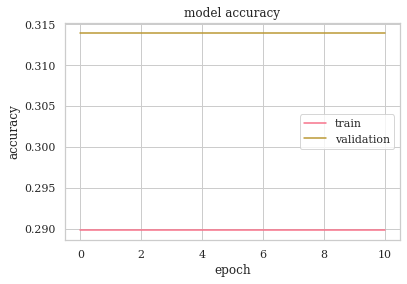

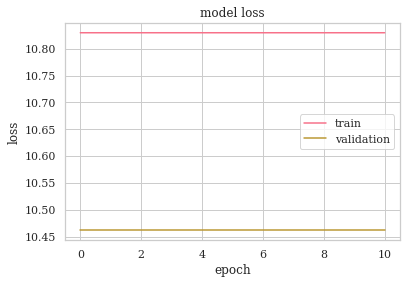

In [17]:

# Training history
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
# summarize history for loss
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
model.save("transfer_learning_model.h5") # saving the model to use it to transfer its wights for our data

In [14]:
from keras.models import load_model
 
# load model
saved_model = load_model('transfer_learning_model.h5')
# summarize model.
saved_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 256, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 256, 4)         512       
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 256, 4)         16        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 256, 8)         32        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 256, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 1, 256, 8)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 32, 8)         

In [15]:
# training and validating the pre-trained model via Moaab dataset for experiment data using transfer learning concept
input1   = Input(shape = (4, 206, 1))
pretrained_model_without_some_layers = Sequential() # initializing a new squential network instead of frequential one, which is the saved model is, to be able to add and delete layers
for layer in saved_model.layers[:-7]: # since the last 6 layer do not have many trainable paramaters, I thaghut it would be a good idea not to freeze those layers
    pretrained_model_without_some_layers.add(layer)
pretrained_model_without_some_layers.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 256, 4)         512       
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 256, 4)         16        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 256, 8)         32        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 256, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 1, 256, 8)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 32, 8)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 32, 8)          0

In [16]:
for layer in pretrained_model_without_some_layers.layers:
    layer.trainable=False
pretrained_model_without_some_layers.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 256, 4)         512       
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 256, 4)         16        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 256, 8)         32        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 256, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 1, 256, 8)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 32, 8)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 32, 8)          0

In [17]:
from tensorflow.keras.layers import SeparableConv2D
F1 = 4
D = 2
norm_rate = 0.25
dropoutRate = 0.75
F2 = F1 * D

In [18]:
## Adding the same layers as in the EEGNet network to the new network 

# separableConv2D = SeparableConv2D(F2, (1, 4), use_bias = False, padding = 'same') # to make the network more trainable on our data
# pretrained_model_without_some_layers.add(separableConv2D)
pretrained_model_without_some_layers.add(BatchNormalization(name = 'batchNormalization'))
pretrained_model_without_some_layers.add(Activation('elu', name = 'activation1'))
pretrained_model_without_some_layers.add(AveragePooling2D((1, 4), name='averagePooling2D'))
pretrained_model_without_some_layers.add(Dropout(dropoutRate, name= 'dropoutLayer'))
pretrained_model_without_some_layers.add(Flatten(name = 'flatten'))
pretrained_model_without_some_layers.add(Dense(4, name = 'dense1', kernel_constraint = max_norm(norm_rate)))
pretrained_model_without_some_layers.add(Dense(1, name = 'dense2', kernel_constraint = max_norm(norm_rate)))
pretrained_model_without_some_layers.add(Activation('sigmoid', name= 'activation2'))



In [21]:
#fitting EEGNet model with training dataset
callback = EarlyStopping(monitor='val_accuracy', patience=500)
opt = keras.optimizers.Adam(learning_rate=0.1)
pretrained_model_without_some_layers.compile(loss='binary_crossentropy',  optimizer=opt, metrics=['accuracy'])
fittedModel= pretrained_model_without_some_layers.fit(X_train_experiment, y_train_experiment, validation_data=(X_validation_experiment, y_validation_experiment), callbacks=[callback],epochs=10000, verbose=1)
pretrained_model_without_some_layers.summary()

Epoch 1/10000
12/12 [==============================] - 0s 33ms/step - loss: 0.7046 - accuracy: 0.4160 - val_loss: 0.6932 - val_accuracy: 0.5520
Epoch 2/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6939 - accuracy: 0.5040 - val_loss: 0.6938 - val_accuracy: 0.5120
Epoch 3/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6966 - accuracy: 0.4827 - val_loss: 0.6951 - val_accuracy: 0.5120
Epoch 4/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6945 - accuracy: 0.4853 - val_loss: 0.6976 - val_accuracy: 0.5200
Epoch 5/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6965 - accuracy: 0.5067 - val_loss: 0.6950 - val_accuracy: 0.4880
Epoch 6/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6971 - accuracy: 0.4907 - val_loss: 0.6953 - val_accuracy: 0.4720
Epoch 7/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6942 - accuracy: 0.5360 - val_loss: 0.6992 - val_accuracy:

12/12 [==============================] - 0s 16ms/step - loss: 0.7018 - accuracy: 0.4560 - val_loss: 0.6929 - val_accuracy: 0.5120
Epoch 114/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6989 - accuracy: 0.4693 - val_loss: 0.6941 - val_accuracy: 0.4800
Epoch 115/10000
12/12 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.5093 - val_loss: 0.6926 - val_accuracy: 0.4880
Epoch 116/10000
12/12 [==============================] - 0s 15ms/step - loss: 0.6995 - accuracy: 0.4853 - val_loss: 0.6947 - val_accuracy: 0.4880
Epoch 117/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6975 - accuracy: 0.4933 - val_loss: 0.6940 - val_accuracy: 0.4720
Epoch 118/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6974 - accuracy: 0.4693 - val_loss: 0.6936 - val_accuracy: 0.4960
Epoch 119/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6987 - accuracy: 0.4667 - val_loss: 0.6902 - val_accuracy: 0

12/12 [==============================] - 0s 27ms/step - loss: 0.6999 - accuracy: 0.4800 - val_loss: 0.6988 - val_accuracy: 0.4880
Epoch 226/10000
12/12 [==============================] - 0s 19ms/step - loss: 0.7008 - accuracy: 0.5040 - val_loss: 0.6959 - val_accuracy: 0.4560
Epoch 227/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6969 - accuracy: 0.4613 - val_loss: 0.6944 - val_accuracy: 0.4880
Epoch 228/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6904 - accuracy: 0.5333 - val_loss: 0.7041 - val_accuracy: 0.4720
Epoch 229/10000
12/12 [==============================] - 0s 19ms/step - loss: 0.7032 - accuracy: 0.4853 - val_loss: 0.6949 - val_accuracy: 0.4320
Epoch 230/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6964 - accuracy: 0.5040 - val_loss: 0.6929 - val_accuracy: 0.5120
Epoch 231/10000
12/12 [==============================] - 0s 21ms/step - loss: 0.6991 - accuracy: 0.5227 - val_loss: 0.6929 - val_accuracy: 0

12/12 [==============================] - 0s 17ms/step - loss: 0.6959 - accuracy: 0.5120 - val_loss: 0.7024 - val_accuracy: 0.4800
Epoch 338/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6962 - accuracy: 0.5067 - val_loss: 0.7023 - val_accuracy: 0.5120
Epoch 339/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6966 - accuracy: 0.5040 - val_loss: 0.6968 - val_accuracy: 0.4880
Epoch 340/10000
12/12 [==============================] - 0s 15ms/step - loss: 0.6961 - accuracy: 0.5147 - val_loss: 0.6938 - val_accuracy: 0.4560
Epoch 341/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6983 - accuracy: 0.4987 - val_loss: 0.6901 - val_accuracy: 0.5440
Epoch 342/10000
12/12 [==============================] - 0s 15ms/step - loss: 0.6995 - accuracy: 0.4507 - val_loss: 0.6929 - val_accuracy: 0.5120
Epoch 343/10000
12/12 [==============================] - 0s 15ms/step - loss: 0.6961 - accuracy: 0.4987 - val_loss: 0.6928 - val_accuracy: 0

12/12 [==============================] - 0s 19ms/step - loss: 0.6948 - accuracy: 0.4933 - val_loss: 0.6948 - val_accuracy: 0.4880
Epoch 450/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6956 - accuracy: 0.4933 - val_loss: 0.6947 - val_accuracy: 0.4480
Epoch 451/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6939 - accuracy: 0.5120 - val_loss: 0.6971 - val_accuracy: 0.4880
Epoch 452/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6953 - accuracy: 0.5013 - val_loss: 0.6946 - val_accuracy: 0.4880
Epoch 453/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6968 - accuracy: 0.5120 - val_loss: 0.6949 - val_accuracy: 0.4720
Epoch 454/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6981 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5120
Epoch 455/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6991 - accuracy: 0.4480 - val_loss: 0.6946 - val_accuracy: 0

12/12 [==============================] - 0s 16ms/step - loss: 0.6963 - accuracy: 0.4907 - val_loss: 0.6943 - val_accuracy: 0.4320
Epoch 562/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6972 - accuracy: 0.4880 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 563/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6977 - accuracy: 0.4853 - val_loss: 0.6914 - val_accuracy: 0.5280
Epoch 564/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6976 - accuracy: 0.5120 - val_loss: 0.6986 - val_accuracy: 0.5120
Epoch 565/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6942 - accuracy: 0.5093 - val_loss: 0.6950 - val_accuracy: 0.4640
Epoch 566/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6980 - accuracy: 0.4907 - val_loss: 0.6943 - val_accuracy: 0.4960
Epoch 567/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6981 - accuracy: 0.4853 - val_loss: 0.6929 - val_accuracy: 0

Epoch 617/10000
12/12 [==============================] - 0s 16ms/step - loss: 0.6991 - accuracy: 0.4533 - val_loss: 0.6979 - val_accuracy: 0.4880
Epoch 618/10000
12/12 [==============================] - 0s 19ms/step - loss: 0.6923 - accuracy: 0.5200 - val_loss: 0.6968 - val_accuracy: 0.4880
Epoch 619/10000
12/12 [==============================] - 0s 22ms/step - loss: 0.6958 - accuracy: 0.5253 - val_loss: 0.6927 - val_accuracy: 0.5360
Epoch 620/10000
12/12 [==============================] - 0s 20ms/step - loss: 0.6971 - accuracy: 0.5147 - val_loss: 0.6963 - val_accuracy: 0.4960
Epoch 621/10000
12/12 [==============================] - 0s 19ms/step - loss: 0.7009 - accuracy: 0.4640 - val_loss: 0.6913 - val_accuracy: 0.5440
Epoch 622/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6951 - accuracy: 0.4960 - val_loss: 0.6942 - val_accuracy: 0.4880
Epoch 623/10000
12/12 [==============================] - 0s 17ms/step - loss: 0.6958 - accuracy: 0.5173 - val_loss: 0.6982 -

In [22]:
scores_training = pretrained_model_without_some_layers.evaluate(X_train_experiment, y_train_experiment, verbose=0)
print("%s: %.2f%%" % ('The training accuracy: ', scores_training[1]*100))

scores_validation = pretrained_model_without_some_layers.evaluate(X_validation_experiment, y_validation_experiment, verbose=0)
print("%s: %.2f%%" % ('The validation accuracy: ', scores_validation[1]*100))

The training accuracy: : 50.40%
The validation accuracy: : 48.80%


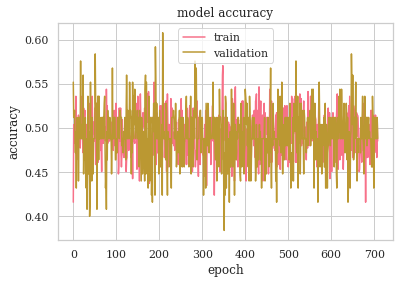

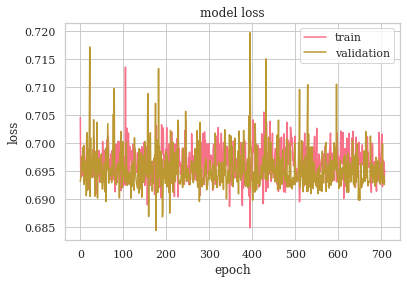

In [23]:

# Training history
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
# summarize history for loss
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()